In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.concatenate((X_train, X_test)) / 255.

In [3]:
class Encoder:
    
    def __init__(self, dim_latent):
        self.dim_latent = dim_latent
        
    def encode_conv(self, input_image):
        with tf.variable_scope("encoder"):
            x = tf.keras.layers.Conv2D(filters=32,
                                       kernel_size=(3,3),
                                       strides=(2,2),
                                       padding="valid",
                                       activation=tf.nn.relu,
                                       name="conv1")(input_image)
            x = tf.keras.layers.Conv2D(filters=64,
                                       kernel_size=(3,3),
                                       strides=(2,2),
                                       padding="valid",
                                       activation=tf.nn.relu,
                                       name="conv2")(x)
            
            shape_small = x.get_shape().as_list()

            flat = tf.keras.layers.Flatten()(x)

            mean = tf.keras.layers.Dense(units=self.dim_latent,
                                         name="mean")(flat)
            log_var = tf.keras.layers.Dense(units=self.dim_latent,
                                            name="log_var")(flat)
            
            sample_normal = tf.random_normal(tf.shape(log_var))
            
            sample_latent = mean + tf.exp(log_var / 2) * sample_normal
            
            return sample_latent, mean, log_var, shape_small
        
    def encode_mlp(self, input_image):
        with tf.variable_scope("encoder"):
            flat = tf.keras.layers.Flatten()(input_image)

            
            x = tf.keras.layers.Dense(units=256,
                                      activation=tf.nn.relu,
                                      name="fc_encoder1")(flat)
            
            mean = tf.keras.layers.Dense(units=self.dim_latent,
                                         name="mean")(x)
            log_var = tf.keras.layers.Dense(units=self.dim_latent,
                                            name="log_var")(x)
            
            sample_normal = tf.random_normal(tf.shape(log_var))
            
            sample_latent = mean + tf.exp(log_var / 2) * sample_normal
            
            return sample_latent, mean, log_var

In [4]:
class Decoder:
        
    def decode_conv(self, latent_vector, shape_small):
        with tf.variable_scope("decoder"):
            x = tf.keras.layers.Dense(units=shape_small[1] * shape_small[2] * shape_small[3],
                                      name="fc_decoder")(latent_vector)
            
            x = tf.reshape(x, (-1, shape_small[1], shape_small[2], shape_small[3]))
            
            x = tf.keras.layers.Conv2DTranspose(filters=64,
                                                kernel_size=(3,3),
                                                strides=(2,2),
                                                padding="valid",
                                                activation=tf.nn.relu,
                                                name="deconv1")(x)
            x = tf.keras.layers.Conv2DTranspose(filters=32,
                                                kernel_size=(3,3),
                                                strides=(2,2),
                                                padding="valid",
                                                activation=tf.nn.relu,
                                                name="deconv2")(x)
            x = tf.keras.layers.Conv2DTranspose(filters=1,
                                                kernel_size=(2,2),
                                                strides=(1,1),
                                                padding="same",
                                                activation=tf.nn.relu,
                                                name="deconv3")(x)

            flat = tf.keras.layers.Flatten()(x)
            x = tf.keras.layers.Dense(units=28*28,
                                      activation=tf.nn.sigmoid,
                                      name="fc_decoder2")(flat)
            reconstruction = tf.reshape(x, (-1, 28, 28, 1))
            
            return reconstruction
        
    def decode_mlp(self, latent_vector):
        with tf.variable_scope("decoder"):
            x = tf.keras.layers.Dense(units=256,
                                      activation=tf.nn.relu,
                                      name="fc_decoder1")(latent_vector)
            
            x = tf.keras.layers.Dense(units=28*28,
                                      activation=tf.nn.sigmoid,
                                      name="fc_decoder3")(x)
            reconstruction = tf.reshape(x, (-1, 28, 28, 1))
            
            return reconstruction

In [5]:
class VAE:
    def __init__(self, input_im_shape, dim_latent):
        # Remove self where not needed
        self.input_im_shape = input_im_shape
        self.dim_latent = dim_latent
                
        with tf.variable_scope("VAE"):
            self.encoder = Encoder(dim_latent)
            self.decoder = Decoder()

            # Data from mnist
            self.original_image = tf.placeholder(tf.float32, (None, *(self.input_im_shape)), name="original_image")
            self.batch_size = tf.placeholder(tf.int64, None, name="batch_size")
            self.dataset = tf.data.Dataset.from_tensor_slices(self.original_image).shuffle(10000).batch(self.batch_size).repeat()
            self.iterator = self.dataset.make_initializable_iterator()

            self.original_image_exp = tf.expand_dims(self.iterator.get_next(), -1)

            self.latent_vec, mean, log_var, shape_small = self.encoder.encode_conv(self.original_image_exp)
            self.reconstruction = self.decoder.decode_conv(self.latent_vec, shape_small)

            # Losses
    #         self.reconstruction_loss = tf.reduce_mean(tf.math.squared_difference(self.reconstruction,
    #                                                                              self.original_image_exp))
            self.reconstruction_loss = tf.reduce_mean(tf.keras.backend.binary_crossentropy(self.original_image_exp,
                                                                                           self.reconstruction))

            self.coeff_latent_loss = tf.placeholder(tf.float32, None, name="coeff_latent_loss")
            self.latent_loss = tf.reduce_mean(0.5 * tf.reduce_sum(mean ** 2 + tf.exp(log_var) - log_var - 1,
                                                                  axis=1))

            self.loss = self.reconstruction_loss + self.coeff_latent_loss * self.latent_loss

            # Optimization
            self.learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)

            # Summaries   
            tf.summary.scalar("reconstruction_loss", self.reconstruction_loss)
            tf.summary.scalar("latent_loss", self.latent_loss)
            tf.summary.scalar("loss", self.loss)
            tf.summary.scalar("mean", tf.reduce_mean(mean))
            tf.summary.scalar("log_var", tf.reduce_mean(log_var))
            tf.summary.image("train_images", self.original_image_exp, 16)
            tf.summary.image("reconstruction", self.reconstruction, 16)
            self.merged_summaries = tf.summary.merge_all()
            
            self.saver = tf.train.Saver()

    def train(self, X_train, batch_size, nb_steps, learning_rate, save_every, eval_every, sess):
        summary_writer = tf.summary.FileWriter("./tensorboard/", sess.graph)

        sess.run(self.iterator.initializer, feed_dict={self.original_image: X_train,
                                                       self.batch_size: batch_size})

        for step in range(1, nb_steps + 1):
            coeff_latent_loss = min(0.05 * step / nb_steps, 0.05)

            _, summaries = sess.run([self.train_op, self.merged_summaries],
                                     feed_dict={self.learning_rate: learning_rate,
                                                self.coeff_latent_loss: coeff_latent_loss})
            
            if step % eval_every == 0:
                self.eval_on_samples(sess)
                summary_writer.add_summary(summaries, step)

            if step % save_every == 0:
                print("Saved at step %i" % step)
                self.saver.save(sess, "./model/model.ckpt")    

    def eval_on_samples(self, sess):
        latent_samples = np.random.randn(16, dim_latent)

        generated_images = sess.run(self.reconstruction,
                                    feed_dict={self.latent_vec: latent_samples})

        for im in range(len(generated_images)):
            plt.imsave("test_images/sampled_%i.png" % im, np.squeeze(generated_images[im]), vmin=0., vmax=1., cmap='gray')
        
    def restore(self, ckpt_file, sess):
        self.saver.restore(sess, ckpt_file)

In [6]:
im_shape = (28, 28)
dim_latent = 2
batch_size = 256
learning_rate = 4e-4

save_every = 1000
eval_every = 100
nb_steps = 10000

In [7]:
vae = VAE(im_shape, dim_latent)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    vae.train(X_train, batch_size, nb_steps, learning_rate, save_every, eval_every, sess)

Saved at step 1000
Saved at step 2000
Saved at step 3000
Saved at step 4000
Saved at step 5000
Saved at step 6000
Saved at step 7000
Saved at step 8000
Saved at step 9000
Saved at step 10000


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt


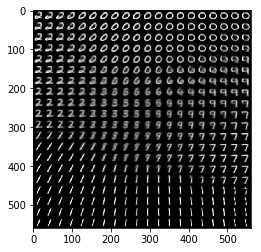

In [9]:
# Linear sampling from latent space
with tf.Session() as sess:
    vae.restore("./model/model.ckpt", sess)

    latent_samples = np.dstack(np.meshgrid(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20))).reshape(-1, 2)        
    
    generated_images = sess.run(vae.reconstruction,
                                feed_dict={vae.latent_vec: latent_samples})

    concat_reconstructions = np.zeros((560, 560))
    for im in range(len(generated_images)):
        row = im // 20
        col = im % 20
        concat_reconstructions[row * 28 : (row + 1) * 28, col * 28 : (col + 1) * 28] = generated_images[im].squeeze()
    
    plt.figure()
    plt.imshow(concat_reconstructions, vmin=0., vmax=1., cmap='gray')
    plt.show()

In [10]:
plt.imsave("2d_latent_space.png", concat_reconstructions, cmap='gray')